In [33]:
import pandas as pd
from pathlib import Path


from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Save the current figure to a file.

    Parameters:
    - fig_id (str): The name or identifier of the figure.
    - tight_layout (bool): Whether to apply tight layout to the figure. Default is True.
    - fig_extension (str): The file extension of the saved figure. Default is "png".
    - resolution (int): The resolution (dots per inch) of the saved figure. Default is 300.
    """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
df = pd.read_csv('malware_dataset.csv')



- **Exports**: This column contains information about the functions or symbols that are exported by the binary file.

- **File_Type**: This column indicates the type of the file, such as executable or dynamic link library (DLL).

- **Imports**: This column contains information about the functions imported by the binary file. 

- **Mnemonics**: This column contains the mnemonics used in the binary file. 

- **Library**: This column contains the libraries that are used or referenced by the binary file.

- **sha256_hash**: This column contains the SHA-256 hash of each binary file.

- **Label**: This column contains the label or classification of the binary file, such as 'malware' or 'benign'. This is the target variable for the binary classification problem.

In [3]:
df.columns

Index(['Exports', 'File_Type', 'Imports', 'Mnemonics', 'Library',
       'sha256_hash', 'Label'],
      dtype='object')

In [4]:
df.File_Type.value_counts()

File_Type
EXE    407
DLL     90
Name: count, dtype: int64

In [7]:
(df.groupby(['File_Type', 'Label'])
 .size()
 .reset_index(name='Count')
)


,File_Type,Label,Count
0,DLL,0,56
1,DLL,1,34
2,EXE,0,188
3,EXE,1,219


In [8]:
df['Mnemonics'] = df['Mnemonics'].apply(eval)

In [9]:
mnemonic_freq =(
    df.explode('Mnemonics')
    .groupby(['Label', 'Mnemonics'])
    .size()
    .reset_index(name='Frequency')
    .sort_values('Frequency', ascending=False)
)

In [22]:
mnemonic_freq

,Label,Mnemonics,Frequency
172,0,mov,3823475
664,1,mov,2409307
776,1,push,1056148
25,0,call,859774
140,0,lea,830827
...,...,...,...
82,0,faddp,1
72,0,cvttps2dq,1
86,0,fidivr,1
937,1,vpsrldq,1


In [27]:
opcodes = ['mov', 'push', 'pop', 'call', 'lea', 'cmp']
filtered_df = mnemonic_freq[mnemonic_freq['Mnemonics'].isin(opcodes)]

filtered_df.sort_values('Mnemonics', ascending=False)

,Label,Mnemonics,Frequency
776,1,push,1056148
251,0,push,243887
739,1,pop,399788
228,0,pop,244597
172,0,mov,3823475
664,1,mov,2409307
140,0,lea,830827
633,1,lea,329855
48,0,cmp,425793
466,1,cmp,415572


In [28]:
filtered_df = filtered_df.sort_values('Mnemonics', ascending=False)

In [29]:
filtered_df['Label'] = filtered_df['Label'].map({0: 'Benign', 1: 'Malware'})

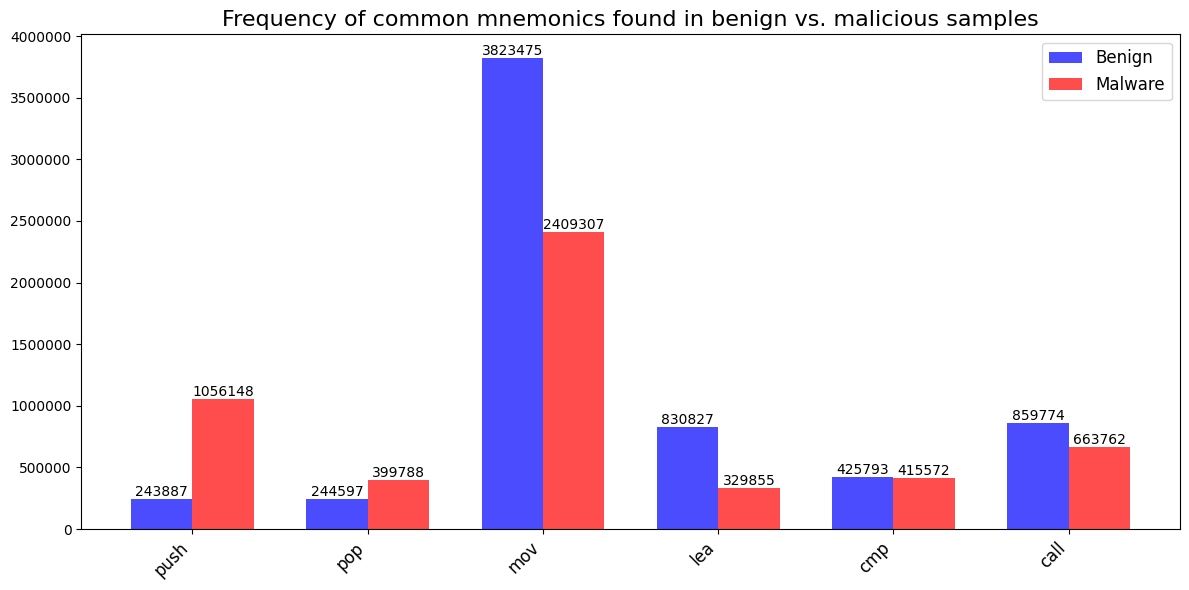

In [32]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
# Set the width of each bar and the positions of the bars
width = 0.35

# Filter the DataFrame for each label
benign_df = filtered_df[filtered_df['Label'] == 'Benign']
malware_df = filtered_df[filtered_df['Label'] == 'Malware']
opcode_list = benign_df['Mnemonics'].to_list()
y_tick_vals = np.arange(0, int(np.ceil(filtered_df['Frequency'].max() / 1000000) * 1000000) + 100000, 500000)

# Create the x-coordinates for each label
x_benign = range(len(benign_df))
x_malware = [i + width for i in x_benign]

#Create the bars
bars_benign = ax.bar(x_benign, benign_df['Frequency'], width, label='Benign', color='b', alpha=0.7)
bars_malware = ax.bar(x_malware, malware_df['Frequency'], width, label='Malware', color='r', alpha=0.7)

# Set the labels and title
#ax.set_ylabel(f'Count', fontsize=12)
ax.set_title('Frequency of common mnemonics found in benign vs. malicious samples', fontsize=16)
ax.set_xticks([i + width / 2 for i in x_benign])
ax.set_xticklabels(opcode_list, rotation=45, ha='right', fontsize=12)

#set y labels
freq = filtered_df['Frequency'].unique()
ax.set_yticks(y_tick_vals)
ax.set_yticklabels(y_tick_vals)
ax.legend(fontsize=12)

# Add frequency values above each bar
for bar in bars_benign:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

for bar in bars_malware:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)
save_fig('Mnemonic_frequency')
plt.show()

In [49]:
# convert the list of mnemonics into a string

X = df['Mnemonics'].apply(lambda x: ' '.join(x))
y = df['Label']

In [50]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Convert opcodes to numerical features using CountVectorizer
vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)

X_test_vectorized = vectorizer.transform(X_test)

### Support Vector Machine (SVM) Model

In [53]:
# Train SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_vectorized, y_train)

SVC(random_state=42)

In [54]:
# make a prediction
svm_predictions = svm_model.predict(X_test_vectorized)

In [55]:
# Evaluate the model
print("SVM Model Evaluation")
print("accuracy:", accuracy_score(y_test, svm_predictions))
print("\nClassification Report:")
print(classification_report(y_test, svm_predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, svm_predictions)
print(cm)

SVM Model Evaluation
accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        48
           1       1.00      0.69      0.82        52

    accuracy                           0.84       100
   macro avg       0.88      0.85      0.84       100
weighted avg       0.88      0.84      0.84       100


Confusion Matrix:
[[48  0]
 [16 36]]


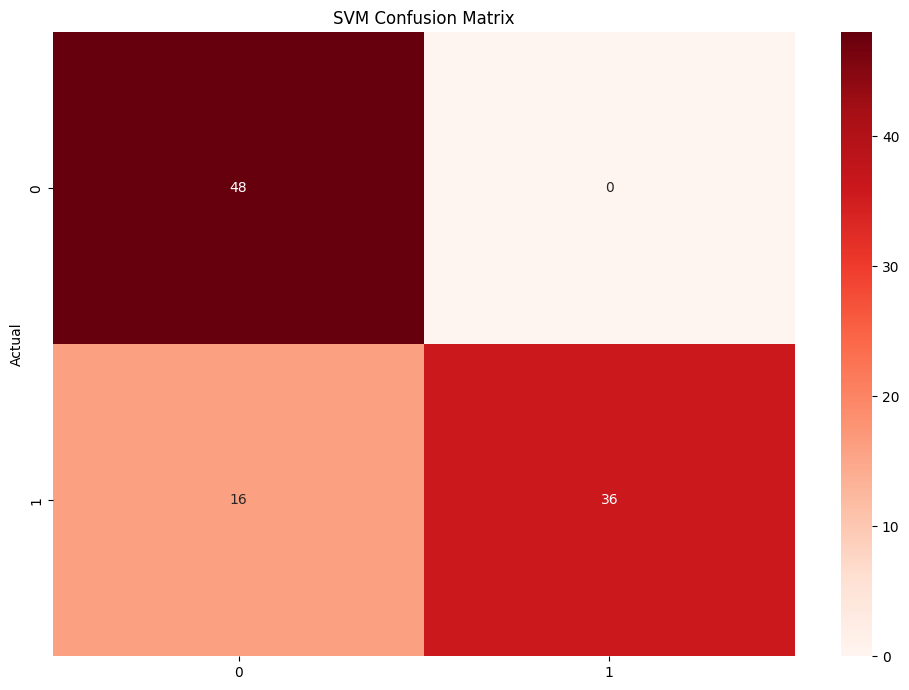

In [56]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, svm_predictions), annot=True, fmt='d',cmap='Reds')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual')
save_fig("svm_confusion_matrix")
plt.show()


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Make a prediction
rf_preds = rf_model.predict(X_test_vectorized)

In [59]:
# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, rf_preds)
print(cm)

Random Forest Model Evaluation:
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       0.98      0.98      0.98        52

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Confusion Matrix:
[[47  1]
 [ 1 51]]


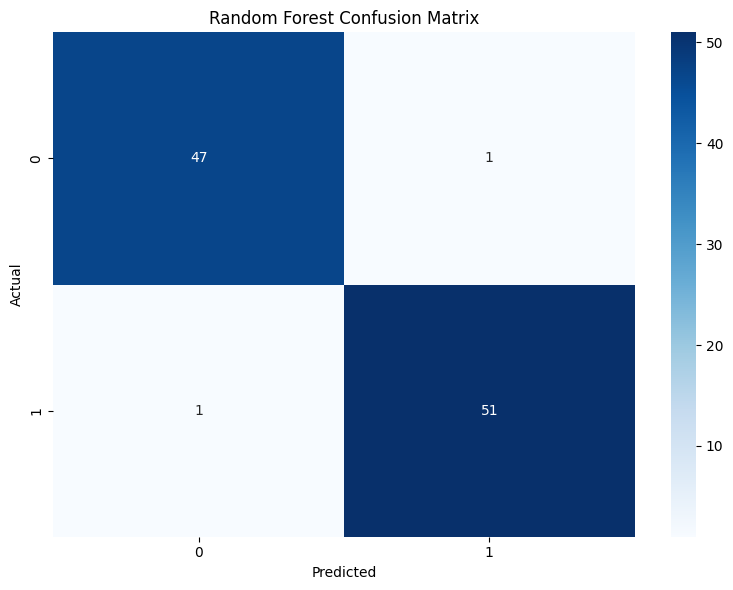

In [60]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,  rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
save_fig("random_forest_confusion_matrix")
plt.show()

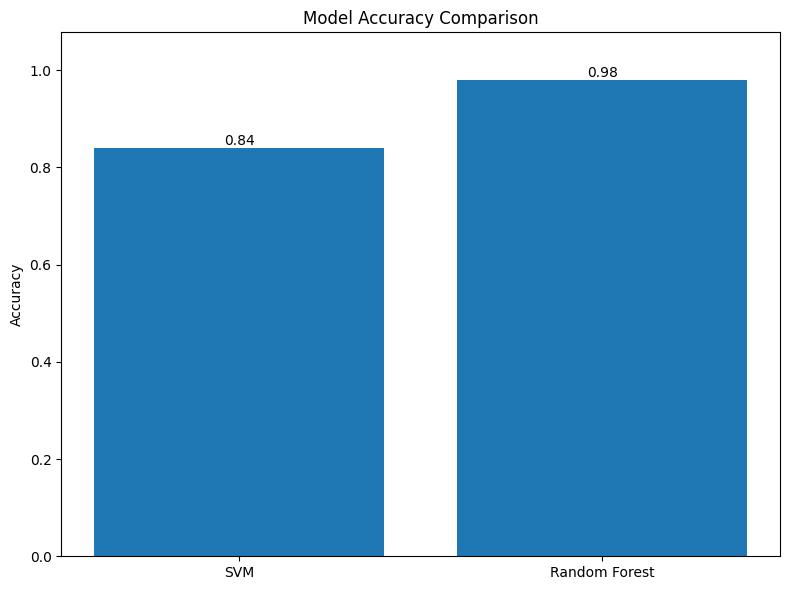

In [61]:
# Model comparison
# Compare model accuracies
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_preds)

plt.figure(figsize=(8, 6))
plt.bar(['SVM', 'Random Forest'], [svm_accuracy, rf_accuracy])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
# Set y-axis limits with some padding
plt.ylim(0, max(svm_accuracy, rf_accuracy) * 1.1)  # 10% padding
for i, v in enumerate([svm_accuracy, rf_accuracy]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
save_fig("model_accuracy_comparison")
plt.show()